<a href="https://www.kaggle.com/code/akouaorsot/full-stack-data-science-ba-flight-reviews?scriptVersionId=141348445" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
British Airways, one of the world's leading airlines, has been synonymous with excellence and reliability for decades. With a rich history and a commitment to providing exceptional customer experiences, British Airways continues to be a preferred choice for travelers worldwide.

As part of a challenging and rewarding data science project at British Airways, I had the opportunity to work on web scraping review data from the renowned Skytrax website. The goal was to collect valuable insights from customer reviews and leverage data-driven approaches to enhance the airline's services and customer satisfaction.

## Table of Contents


# Loading

In [1]:
## Importing Libraries
import os           # operating system
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import category_encoders as ce # Encode Categorical Variables

import matplotlib.pyplot as plt # data visualization

import seaborn as sns
import math

sns.set_style("darkgrid")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
## Importing the dataset
paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

paths

['/kaggle/input/british-airways-passenger-reviews-2016-2023/British_Airway_Review.csv']

# Overview

In [3]:
# Snapshot of the first 5 rows
df = pd.read_csv(paths[0])
df.head()

,reviews,date,country,seat_type,recommended,stars,route,type_of_traveller
0,✅ Trip Verified | I had the most fantastic BA...,1st August 2023,Hong Kong,Business Class,yes,5,Heathrow to Las Vegas,Family Leisure
1,✅ Trip Verified | Couldn’t book in online. Ar...,31st July 2023,United Kingdom,Economy Class,no,3,Rome to Heathrow,Solo Leisure
2,✅ Trip Verified | London Heathrow to Mumbai in...,31st July 2023,Iceland,Business Class,yes,3,Gatwick to Venice,Solo Leisure
3,"✅ Trip Verified | Keflavík, Iceland to London ...",31st July 2023,Iceland,Business Class,yes,5,London to Luanda,Couple Leisure
4,✅ Trip Verified | Terrible Experience with Bri...,29th July 2023,Canada,Economy Class,no,5,Denver to Heathrow,Family Leisure


In [4]:
# Shape of data: No. of rows and columns
no_rows, no_cols = df.shape

# Check for missing values
null_values = df.isnull().sum().sum()

# No. of duplicates values
duplicates_n = df[df.duplicated()].shape[0]


# Diagnostics results
data_check = """
- The data has {0} rows and {1} columns
- There are {2} null/na values and {3} duplicated rows. 
""" 

print(data_check.format(no_rows, no_cols,
                        null_values, duplicates_n))


- The data has 2500 rows and 8 columns
- There are 0 null/na values and 0 duplicated rows. 



In [5]:
# # Examine unique values for each categorical variable
# """
# - col:
#     - 
# """
# Unique value counts for categorical columns
for col in df.columns[2:]:
    print(col)
    col_cats_count = df[col].value_counts(normalize=True, sort=True)
    n_cat = len(col_cats_count.keys())
    freq = dict(col_cats_count)
    if n_cat <= 10:
        print(n_cat)
        print(freq)
    else:
        print(n_cat)

country
67
seat_type
4
{'Economy Class': 0.5452, 'Business Class': 0.3016, 'Premium Economy': 0.0992, 'First Class': 0.054}
recommended
2
{'no': 0.648, 'yes': 0.352}
stars
5
{3: 0.4548, 5: 0.2728, 1: 0.0908, 9: 0.0908, 7: 0.0908}
route
10
{'Heathrow to Las Vegas': 0.1, 'Rome to Heathrow': 0.1, 'Gatwick to Venice': 0.1, 'London to Luanda': 0.1, 'Denver to Heathrow': 0.1, 'BKK to LHR': 0.1, 'London to Tampa': 0.1, 'London to Sydney': 0.1, 'LHR to CPT': 0.1, 'BLR to LHR': 0.1}
type_of_traveller
4
{'Couple Leisure': 0.4, 'Family Leisure': 0.2, 'Solo Leisure': 0.2, 'Business': 0.2}


# Exploratory Data Analysis

In [6]:
# Traveller Profiling Analysis
profile_columns = [
    'country',
    'seat_type',
    'type_of_traveller'
]

# Subset of data with demographic information
travellers_details = df[profile_columns]
profile_stats = travellers_details.describe()
profile_stats

,country,seat_type,type_of_traveller
count,2500,2500,2500
unique,67,4,4
top,United Kingdom,Economy Class,Couple Leisure
freq,1552,1363,1000


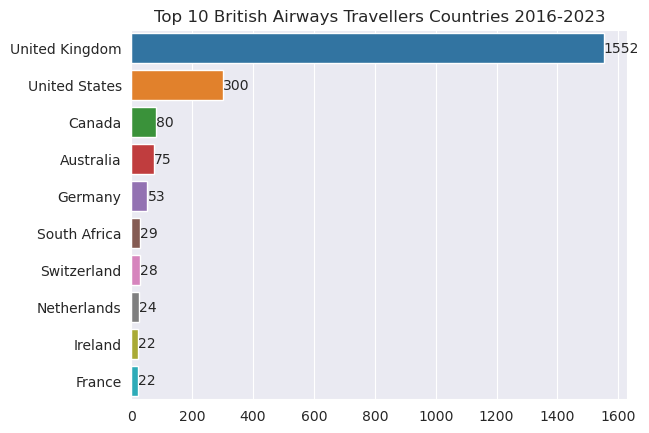

In [7]:
# Obtain value counts by country
country_freq = travellers_details['country'].value_counts(normalize=False, sort=True)
countries_top = list(country_freq.index)[:10]
freq_counts_top = list(country_freq.values)[:10]

# Disribution of top traverlers' origin countries
ax = sns.barplot(x=freq_counts_top, y=countries_top, 
            orient = 'h'
       )

ax.bar_label(ax.containers[0])
plt.title('Top 10 British Airways Travellers Countries 2016-2023')
plt.show()

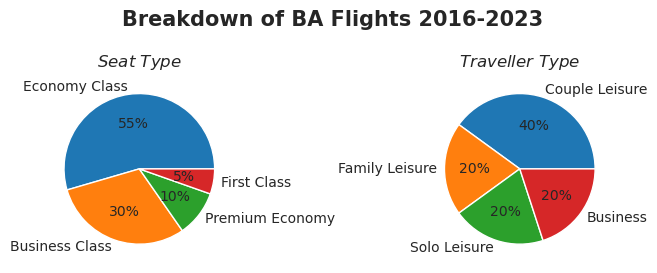

In [8]:
# Proportions by seat type
seats_freq = travellers_details['seat_type'].value_counts(sort=True)
seat_type = list(seats_freq.index)
seat_counts = list(seats_freq.values)

# Proportions by seat type
type_freq = travellers_details['type_of_traveller'].value_counts(sort=True)
types = list(type_freq.index)
type_counts = list(type_freq.values)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Breakdown of BA Flights 2016-2023", y=0.8, fontsize=15, fontweight='bold')
ax1.pie(labels=seat_type, x=seat_counts, autopct='%.0f%%')
ax1.set_title('${Seat}$ ${Type}$')
ax2.pie(labels=types, x=type_counts , autopct='%.0f%%')
ax2.set_title("${Traveller}$ ${Type}$")

fig.tight_layout(pad=.75)
#plt.title('Breakdown of Seat Type & Traveller Type at BA Flights 2016-2023')
plt.show()

# Statistical Analysis

In [9]:
# Correlation: Strongest demograpic info for strong recommendation

In [10]:
# Does more premimum seat type rate their experience to be better?

In [11]:
# Which routes has the highest recommendation score?

# Feature Transformation/Engineering

With data cleaning taking up a considerable chunk of data science workflow, it is critical to know how to assess, improve, and produce data quality. Every subsequent steps from analysis to machine learning modeling hinges on having good data. And so, this project will focus on practicing best practices when it comes to data cleaning to ensure higher quality and usability. 

In that vein, we examined various sources, especially the following three in an attempt to draft a comprehensive map for the cleaning process: 
* [World Bank Data Cleaning Checklist](https://dimewiki.worldbank.org/Checklist:_Data_Cleaning)
* [Mariann Beargie on Medium](https://mariannbea.medium.com/are-you-sure-your-data-is-completely-clean-use-this-checklist-to-help-8cb415a8b0e0)
* [DataCamp Data Cleaning Infographic](https://www.datacamp.com/blog/infographic-data-cleaning-checklist)

Based on the sources above, we modelled our steps and ensure that we could produce a score on the scale of 1 to 10 before and after cleaning.

In [12]:
# # Create a different column "trip verified" to seperate them properly
# df['trip_verified'] = np.where(df['reviews'].str.contains("Trip Verified"), 1, 0) 

# # Capture the main content of the reviews and create a list of each word 
# df['reviews_verif_drop'] = df['reviews'].str.replace("✅ Trip Verified \| ","").str.strip()
# df['reviews_bag_of_words'] = df['reviews_verif_drop'].str.split(" ")

# # Converting 'date' column to datetime
# df['date'] = pd.to_datetime(df['date'])

# # New snapshot of first 5 rows after transformation
# df.head()

In [13]:
# # Some routes have airport codes while others don't
# # List of airports codes to standardize the information in departure and arrival locations
# airport_codes = {
#     "London": "LHR",
#     "Heathrow": "LHR",
#     "Las Vegas": "LAS",
#     "Luanda": "LAD",
#     "Denver": "DEN",
#     "Rome": "FCO",
#     "Gatwick": "LGW",
#     "Venice": "VCE",
#     "Tampa": "TPA",
#     "Sydney": "SYD",
#     "Bangkok": "BKK",
#     "Cape Town": "CPT",
#     "Bangalore": "BLR"
# }

# df = df.apply(lambda x: x.replace(airport_codes, regex=True))
# df.head()

In [14]:

# # In the airline industry, seat pricing implies a given order. 
# # So, we will encode accordingly
# ordinal_encoder = ce.OrdinalEncoder(cols=['seat_type', 'stars'],return_df=True,
#                        mapping=[
#                            {'col':'seat_type',
#                             'mapping':{'Economy Class':0,'Premium Economy':1,
#                                             'Business Class':2,'First Class':3}},
#                            {'col':'stars',
#                             'mapping':{1:0, 3:1, 5:2,7:3, 9:4}}])


# # 'recommended' and 'trip_verified' are binary categorical variables so, will be encoded as such
# binary_encoder= ce.BinaryEncoder(cols='trip_verified',return_df=True)

# ## 'type_of_traveller' and 'route' are both nominal categorical variables
# # With 4 and 10 categories respectively
# #So we will one-hot-encoding
# one_hot_encoder = ce.OneHotEncoder(cols=["type_of_traveller", "route"], use_cat_names=True,
#                                    return_df=True)

# # The 'country' column is categorical feature, but with 67 distinct entities
# # To avoid increasing the dimensionality in the data set, we
# # used frequency encoding. 
# freq_encoder = ce.CountEncoder(cols=['country'], normalize=True, return_df=True)

In [15]:
# def encoding_cat_vars(data, encoders):
#     """ Encoding categorical variables

#     Inputs
#     -------
#         data: dataframe
#         encoders: list of dictionaries with the encoders

#     Returns transformed dataframe
#     """

#     # Looping through all encoders for an in-place encoding
#     for enc in encoders:
#         # Define the key-value pair in context
#         enc_name = list(enc.keys())[0]
#         enc_vars = list(enc.values())[0]

#         # Special Case for frequency encoding
#         if enc_name == 'freq_encoder':
#             # New columns from list of columns to encode 
#             # with a frequency encoder
#             col = enc_vars[0]
#             func = enc_vars[1]
#             data[col+'_encoded'] = func.fit_transform(data[col])

#         # For all other cases, apply 'fit_transform' inplace
#         else:
#             func = enc_vars
#             data = func.fit_transform(data)

#     # New dataframe after encoding
#     return data


# # Applying all changes using the defined function above
# df_encoded = encoding_cat_vars(data = df, 
#                                encoders = [{'ordinal_encoder': ordinal_encoder},
#                                            {'binary_encoder': binary_encoder},
#                                            {'one_hot_encoder': one_hot_encoder},
#                                            {'freq_encoder': ['country', freq_encoder]}
#                                             ]
#                                )

# df_encoded.head()

# Final Dataset

In [16]:
# After all pre-processing steps,
# Save onto a new csv file
#df_encoded.to_csv("BA_Flights_Reviews_processed.csv", header=True)

# Machine Learning

In [17]:
# Use recommended as target variable
# Use label encoding

# NLP

In [18]:
# Strategy 2: Perform Sentiment Analysis to create sentiment_label (positive or negative)
# Create wordcloud

# Business Analysis & Recommendations